In [919]:
import pandas as pd
df=pd.read_csv("Data Complete.csv")
df.sample(5)

,Unnamed: 0,Date,Open,Close,Adj Close,High,Low,Volume,MACD_Line,MACD_Signal,...,SMA_100,EMA_100,SMA_200,EMA_200,Close_LAG1,Close_LAG2,Close_LAG3,Close_LAG5,Close_LAG7,Close_LAG14
3720,3734,2010-08-13,221.839981,223.805786,200.472076,227.165970,221.839981,30512197,-4.044431,-3.040535,...,214.439314,212.449200,213.084442,210.535203,222.319992,224.754410,225.817322,228.606033,232.251938,240.720947
2432,2446,2005-05-26,37.916634,37.873791,32.608002,38.095150,37.598877,108808070,-0.054017,-0.065682,...,32.639326,32.477382,31.711308,31.702181,37.891644,37.916634,37.927345,37.438213,37.556034,39.209084
6909,6923,2023-07-18,1300.045044,1301.637207,1287.525757,1309.482666,1288.968994,25867313,34.607454,26.584982,...,1114.922466,1144.696874,1128.768120,1133.420003,1290.676636,1264.832642,1265.894043,1275.908569,1215.406006,1152.111328
4617,4631,2014-03-31,209.439331,212.753799,197.223145,214.822464,208.742157,18751896,4.485549,3.689654,...,181.682950,181.776341,181.927002,180.425850,209.416473,205.896301,203.713333,206.959213,207.096359,202.398972
919,933,1999-07-29,12.631737,12.838815,9.461040,12.942353,12.392527,141625103,-0.041707,0.031913,...,8.201618,8.545196,7.246670,7.861351,12.499636,12.196160,12.342542,12.892369,12.724565,12.860236


In [920]:
df=df.drop(columns=['Unnamed: 0'])

# 5. Preparing Training & Testing Data for different cases

In [921]:
train_size=int(len(df)*0.8)

### ARIMA

In [922]:
train_arima=df['Adj Close'].iloc[:train_size]
test_arima=df['Adj Close'].iloc[train_size:]

print(type(train_arima),train_arima.shape)
print(type(test_arima),test_arima.shape)

<class 'pandas.core.series.Series'> (5964,)
<class 'pandas.core.series.Series'> (1492,)


### PROPHET

In [923]:
prophet_df=df.reset_index()[['Date','Adj Close']]
prophet_df.columns=["ds","y"]

train_prophet=prophet_df.iloc[:train_size]
test_prophet=prophet_df.iloc[train_size:]

### LSTM/GRU for multi-step

In [924]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [925]:
data_multi=scaler.fit_transform(df[['Adj Close']])

In [926]:
import numpy as np
def create_multistep_sequences(data,n_steps,k):
    x=[]
    y=[]
    for i in range(n_steps,len(data)-k+1):
        x.append(data[i-n_steps:i])    # past n days
        y.append(data[i:i+k])          # next k days
    return np.array(x),np.array(y)

n_steps=100
k=1
x,y=create_multistep_sequences(data_multi,n_steps,k)

x=x.reshape((x.shape[0],x.shape[1],1))
x_train_multistep,x_test_multistep=x[:train_size],x[train_size:]
y_train_multistep,y_test_multistep=y[:train_size],y[train_size:]

### XGBOOST/RANDOMFOREST for next day close price and direction

In [927]:
next_day_df=df.drop(columns=['Date'])
next_day_df['Target']=next_day_df['Close'].shift(-1)
x_next_day=next_day_df.drop(columns=['Target'])
y_next_day=next_day_df['Target']

In [928]:
x_train_next_day,x_test_next_day=x_next_day[:train_size],x_next_day[train_size:]
y_train_next_day,y_test_next_day=y_next_day[:train_size],y_next_day[train_size:]





def prepare_xy(df, mode="regression", n_steps_in=60, n_steps_out=1):
    """
    mode: "regression", "classification", "arima", "prophet", "lstm"
    """
    if mode == "arima":
        return None, df["Close"]
    
    if mode == "prophet":
        prophet_df = df.reset_index()[["Date", "Close"]]
        prophet_df.columns = ["ds", "y"]
        return None, prophet_df
    
    if mode in ["regression", "classification"]:
        X = df[["Open", "High", "Low", "Close", "Volume", "MA_20", "MA_50", "Volatility"]]
        if mode == "regression":
            y = df["Close"].shift(-1)
        else:
            y = (df["Close"].shift(-1) > df["Close"]).astype(int)
        return X[:-1], y[:-1]
    
    if mode == "lstm":
        data = df["Close"].values
        X, y = [], []
        for i in range(len(data) - n_steps_in - n_steps_out):
            X.append(data[i:i+n_steps_in])
            y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
        return np.array(X), np.array(y)


from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

def train_model(X, y, mode="regression", model_type="xgb", n_steps_in=60, n_steps_out=1):
    if model_type == "arima":
        model = ARIMA(y, order=(5,1,0)).fit()
        return model
    
    if model_type == "prophet":
        model = Prophet()
        model.fit(y)  # here y is prophet_df
        return model
    
    if model_type in ["xgb", "rf"]:
        if mode == "regression":
            model = XGBRegressor() if model_type=="xgb" else RandomForestRegressor()
        else:
            model = XGBClassifier() if model_type=="xgb" else RandomForestClassifier()
        model.fit(X, y)
        return model
    
    if model_type in ["lstm", "gru"]:
        model = Sequential()
        if model_type == "lstm":
            model.add(LSTM(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        else:
            model.add(GRU(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer="adam", loss="mse")
        model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=10, batch_size=32, verbose=1)
        return model

# 6. Model Training

## (i) ARIMA

In [929]:
import pmdarima as pm

train_arim=np.log(train_arima)
test_arim=np.log(test_arima)

model_arima=pm.auto_arima(train_arim,verbose=False)
forecast_arima=model_arima.predict(n_periods=len(test_arim))

forecast_arima=np.exp(forecast_arima)

root_mean_squared_error(test_arima,forecast_arima)

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

229.64595309841928

In [930]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test_arima,forecast_arima)*100

15.916955567111618

In [931]:
a=df['Date'].iloc[train_size:]
a=pd.to_datetime(a)

In [932]:
a.dtype

dtype('<M8[ns]')

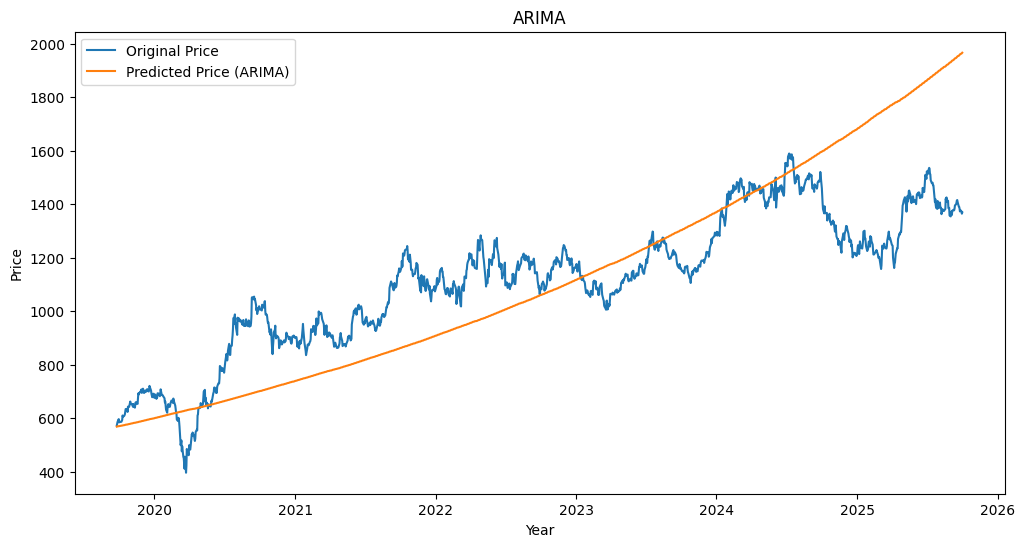

In [933]:
plt.figure(figsize=(12,6))
plt.title("ARIMA")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_arima,label="Original Price")
plt.plot(a,forecast_arima,label='Predicted Price (ARIMA)')
plt.legend()

## (ii) PROPHET

In [934]:
from prophet import Prophet

train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])

m=Prophet()
m.fit(train_prophet)

future_prophet=m.make_future_dataframe(periods=len(test_prophet))
forecast_prophet=m.predict(future_prophet)

/var/folders/nc/hvlqvddd2xj11jl0l69nx3580000gn/T/ipykernel_19660/2201988977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])
20:29:45 - cmdstanpy - INFO - Chain [1] start processing
20:29:46 - cmdstanpy - INFO - Chain [1] done processing


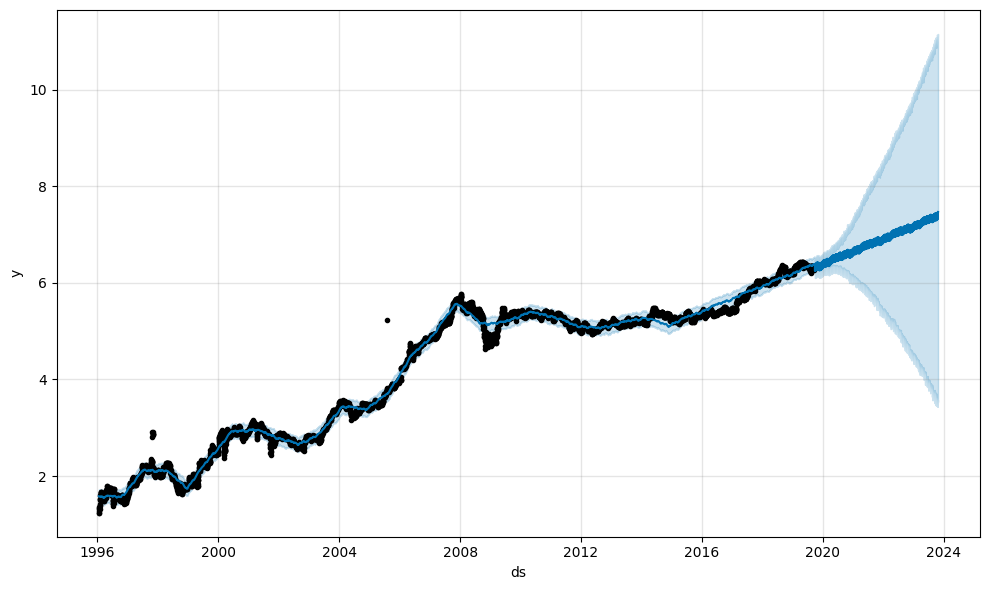

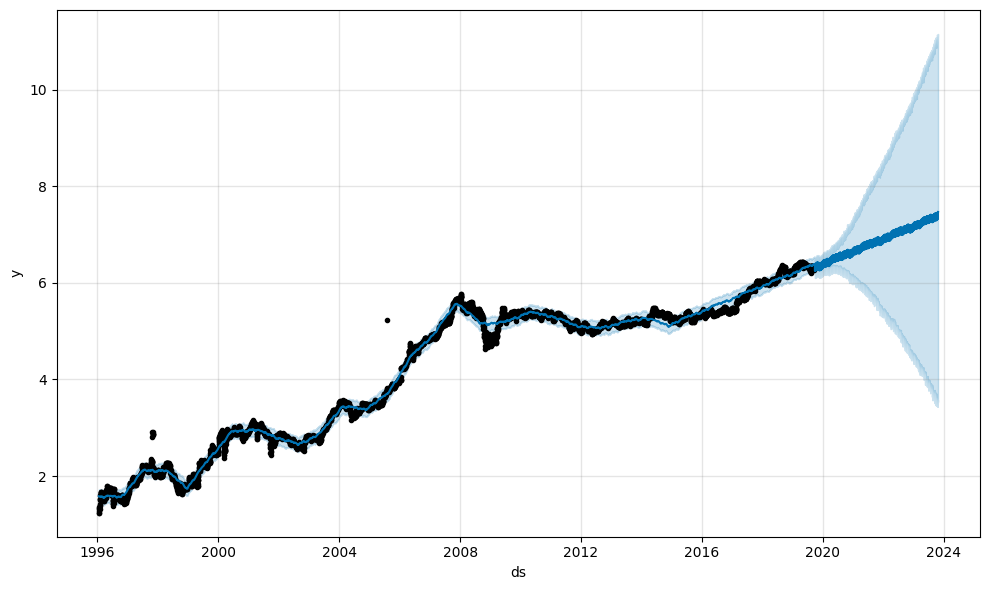

In [935]:
m.plot(forecast_prophet)

In [936]:
root_mean_squared_error(test_prophet['y'],forecast_prophet['yhat'].iloc[train_size:])

0.19791418821492304

In [937]:
test_prophet['y'],forecast_prophet['yhat'].iloc[train_size:]

(5964    6.349857
 5965    6.363248
 5966    6.372650
 5967    6.390218
 5968    6.369474
           ...   
 7451    7.224316
 7452    7.228098
 7453    7.224608
 7454    7.218177
 7455    7.221617
 Name: y, Length: 1492, dtype: float64,
 5964    6.392906
 5965    6.394216
 5966    6.391211
 5967    6.250953
 5968    6.251002
           ...   
 7451    7.323277
 7452    7.324711
 7453    7.466290
 7454    7.467464
 7455    7.469821
 Name: yhat, Length: 1492, dtype: float64)

In [938]:
np.exp(test_prophet['y']),np.exp(forecast['yhat'].iloc[train_size:])

(5964     572.410645
 5965     580.127502
 5966     585.607605
 5967     595.986206
 5968     583.750977
            ...     
 7451    1372.400024
 7452    1377.599976
 7453    1372.800049
 7454    1364.000000
 7455    1368.699951
 Name: y, Length: 1492, dtype: float64,
 5964     586.781027
 5965     588.768331
 5966     588.166227
 5967     591.277324
 5968     593.944955
            ...     
 7462    1713.221498
 7463    1716.249839
 7464    1721.816444
 7465    1727.125336
 7466    1724.791387
 Name: yhat, Length: 1503, dtype: float64)

In [939]:
test_proph=np.exp(test_prophet['y'])
predict_proph=np.exp(forecast_prophet['yhat'].iloc[train_size:])

In [940]:
root_mean_squared_error(test_proph,predict_proph)

198.8017860814636

In [941]:
mean_absolute_percentage_error(test_proph,predict_proph)*100

15.45012172018328

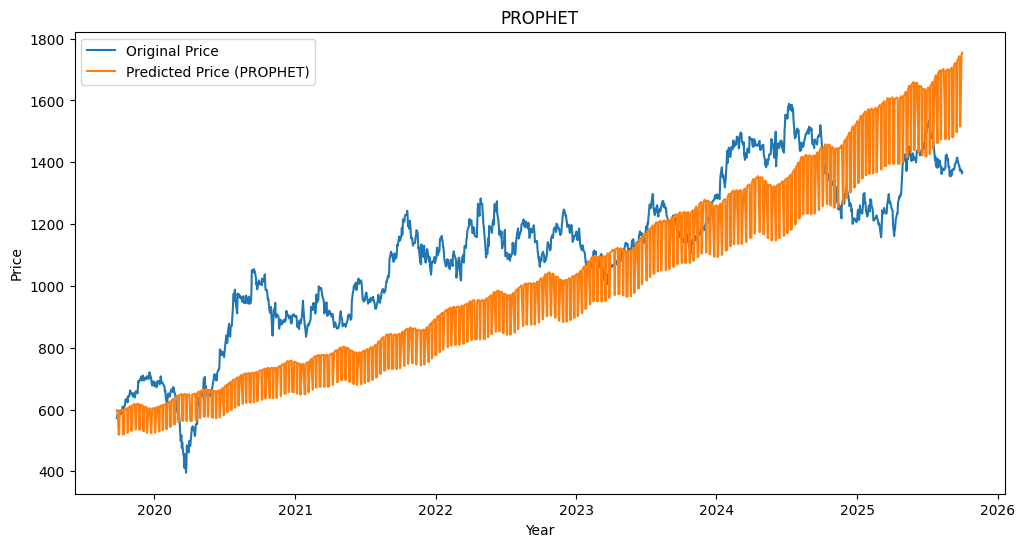

In [942]:
plt.figure(figsize=(12,6))
plt.title("PROPHET")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_proph,label='Original Price')
plt.plot(a,predict_proph,label='Predicted Price (PROPHET)')
plt.legend()

## (iii) LSTM

In [943]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,GRU

In [944]:
lstm_model=Sequential([
    LSTM(80,input_shape=(x_train_multistep.shape[1],1),return_sequences=True),
    #Dropout(0.2),
    LSTM(60),
    #Dropout(0.3),
    Dense(y_train_multistep.shape[1])
])

lstm_model.summary()

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_82 (LSTM)                  │ (None, 100, 80)        │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 60)             │        33,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,141 (234.93 KB)

 Trainable params: 60,141 (234.93 KB)

 Non-trainable params: 0 (0.00 B)

In [945]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
history_lstm=lstm_model.fit(x_train_multistep,y_train_multistep,epochs=30,batch_size=32,validation_split=0.2)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 5.7240e-04 - val_loss: 1.8753e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.3458e-05 - val_loss: 1.0611e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.3370e-05 - val_loss: 1.3070e-04
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.0999e-05 - val_loss: 2.4814e-04
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.7566e-05 - val_loss: 8.3184e-05
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.5973e-05 - val_loss: 1.3017e-04
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3092e-05 - val_loss: 1.5649e-04
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.2079e-05 - val_loss: 1.1310e-04
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3387e-05 - val_loss: 7.1897e-05
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.2211e-05 - val_loss: 9.8216e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/

In [946]:
y_pred_lstm=lstm_model.predict(x_test_multistep)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [947]:
y_pred_lstm.shape,y_test_multistep.shape

((1392, 1), (1392, 1, 1))

In [948]:
y_pred_lstm,y_test_multistep

(array([[0.40602723],
        [0.40933058],
        [0.40964285],
        ...,
        [0.82140106],
        [0.8202127 ],
        [0.8170837 ]], dtype=float32),
 array([[[0.42207552]],
 
        [[0.41703971]],
 
        [[0.40547281]],
 
        ...,
 
        [[0.86356845]],
 
        [[0.85801878]],
 
        [[0.86098276]]]))

In [949]:
if y_test_multistep.shape[1]==1:
    y_test_lstm_squeezed=y_test_multistep.reshape(-1,1)
else:
    y_test_lstm_squeezed=np.squeeze(y_test_multistep)

In [950]:
y_test_lstm_squeezed.shape

(1392, 1)

In [951]:
root_mean_squared_error(y_test_lstm_squeezed,y_pred_lstm)

0.03526200290589806

In [952]:
real_lstm=scaler.inverse_transform(y_test_lstm_squeezed)
predicted_lstm=scaler.inverse_transform(y_pred_lstm)

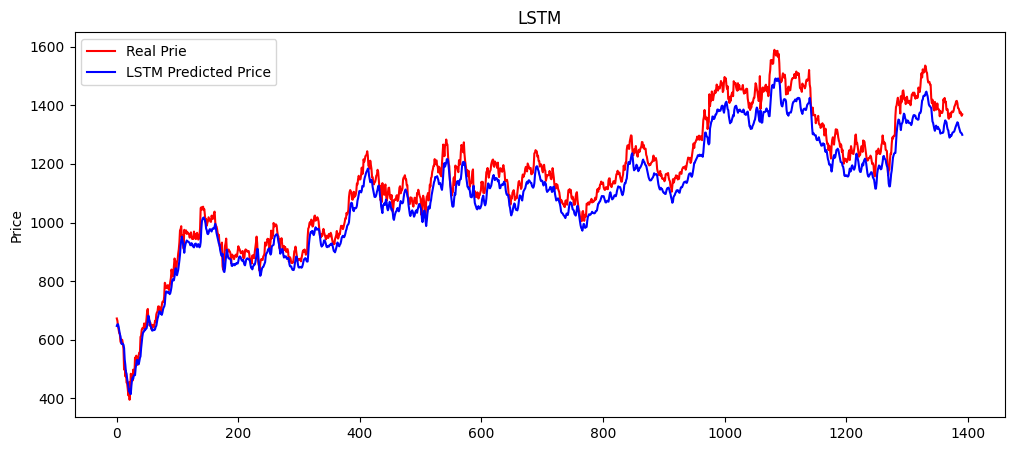

In [953]:
plt.figure(figsize=(12,5))
plt.title("LSTM")
plt.ylabel("Price")
plt.plot(real_lstm,'r',label="Real Prie")
plt.plot(predicted_lstm,'b',label="LSTM Predicted Price")
plt.legend()

In [954]:
root_mean_squared_error(real_lstm,predicted_lstm)

55.91458923632246

In [955]:
mean_absolute_percentage_error(real_lstm,predicted_lstm)*100

4.255547218235653

## (iv) GRU

In [956]:
gru_model=Sequential([
    GRU(80,input_shape=(x_train_multistep.shape[1],1),return_sequences=True),
    GRU(60),
    Dense(y_train_multistep.shape[1])
])
gru_model.summary()

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, 100, 80)        │        19,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 60)             │        25,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,541 (177.89 KB)

 Trainable params: 45,541 (177.89 KB)

 Non-trainable params: 0 (0.00 B)

In [957]:
gru_model.compile(loss='mean_squared_error',optimizer='adam')
history_gru=gru_model.fit(x_train_multistep,y_train_multistep,epochs=30,batch_size=32,validation_split=0.2)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4.9176e-04 - val_loss: 4.2172e-05
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 8.5274e-06 - val_loss: 5.8426e-05
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 9.0971e-06 - val_loss: 4.3183e-05
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.2214e-05 - val_loss: 3.6656e-05
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.7418e-06 - val_loss: 5.1723e-05
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.0400e-05 - val_loss: 5.3319e-05
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 8.0505e-06 - val_loss: 9.3145e-05
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 9.2870e-06 - val_loss: 5.5540e-05
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.5985e-05 - val_loss: 3.6481e-05
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 7.2883e-06 - val_loss: 2.7309e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/

In [958]:
y_pred_gru=gru_model.predict(x_test_multistep)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [959]:
y_pred_gru.shape,y_test_multistep.shape

((1392, 1), (1392, 1, 1))

In [960]:
y_pred_gru,y_test_multistep

(array([[0.41873738],
        [0.4263885 ],
        [0.42393896],
        ...,
        [0.8595683 ],
        [0.8572747 ],
        [0.852381  ]], dtype=float32),
 array([[[0.42207552]],
 
        [[0.41703971]],
 
        [[0.40547281]],
 
        ...,
 
        [[0.86356845]],
 
        [[0.85801878]],
 
        [[0.86098276]]]))

In [961]:
if y_test_multistep.shape[1]==1:
    y_test_gru_squeezed=y_test_multistep.reshape(-1,1)
else:
    y_test_gru_squeezed=np.squeeze(y_test_multistep)

In [962]:
y_test_gru_squeezed.shape

(1392, 1)

In [963]:
root_mean_squared_error(y_test_gru_squeezed,y_pred_gru)

0.012422008707073903

In [964]:
y_test_gru_squeezed,y_pred_gru

(array([[0.42207552],
        [0.41703971],
        [0.40547281],
        ...,
        [0.86356845],
        [0.85801878],
        [0.86098276]]),
 array([[0.41873738],
        [0.4263885 ],
        [0.42393896],
        ...,
        [0.8595683 ],
        [0.8572747 ],
        [0.852381  ]], dtype=float32))

In [965]:
real_gru=scaler.inverse_transform(y_test_gru_squeezed)
predicted_gru=scaler.inverse_transform(y_pred_gru)

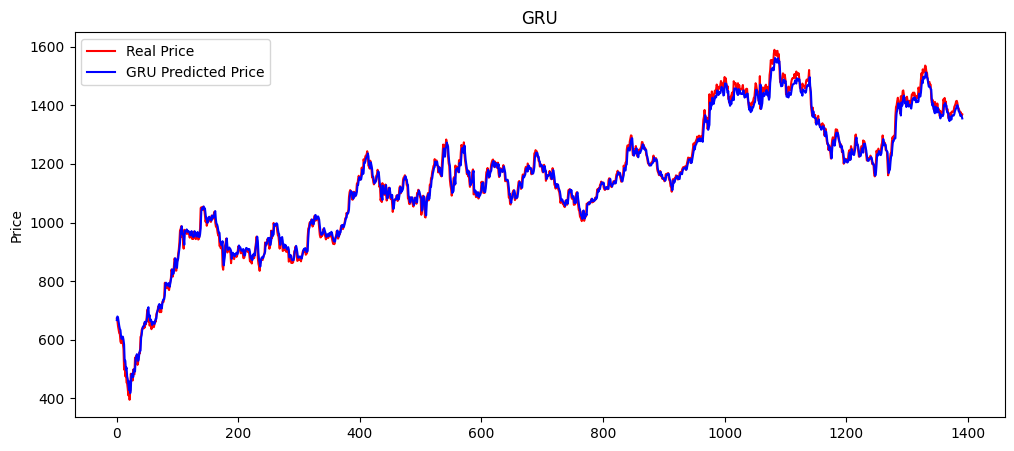

In [966]:
plt.figure(figsize=(12,5))
plt.title("GRU")
plt.ylabel("Price")
plt.plot(real_gru,'r',label="Real Price")
plt.plot(predicted_gru,'b',label="GRU Predicted Price")
plt.legend()

In [967]:
root_mean_squared_error(real_gru,predicted_gru)

19.697445393834585

In [968]:
mean_absolute_percentage_error(real_gru,predicted_gru)*100

1.359575968126134

## (v) XGBOOST for next day close price/direction

In [969]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
model_xgb=XGBRegressor()
model_xgb.fit(x_train_next_day,y_train_next_day)
y_pred_next_day_xgb=model_xgb.predict(x_test_next_day)

In [970]:
pred_xgb=y_pred_next_day_xgb[:-1]
test_xgb=y_test_next_day[:-1]

In [971]:
root_mean_squared_error(test_xgb,pred_xgb)

559.7568289399749

In [972]:
mean_absolute_percentage_error(test_xgb,pred_xgb)*100

41.88873222767106

from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 500],        # number of boosting rounds
    "max_depth": [3, 5, 7],                 # depth of trees
    "learning_rate": [0.01, 0.05, 0.1],     # step size shrinkage
    "subsample": [0.6, 0.8, 1.0],           # % of samples used per tree
    "colsample_bytree": [0.6, 0.8, 1.0],    # % of features used per tree
    "gamma": [0, 0.1, 0.3],                 # min loss reduction for split
    "reg_alpha": [0, 0.01, 0.1],            # L1 regularization
    "reg_lambda": [1, 1.5, 2]               # L2 regularization
}

grid_search=GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [986]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 500],        # number of boosting rounds
    "max_depth": [3, 5, 7],                 # depth of trees
    "learning_rate": [0.01, 0.05, 0.1],     # step size shrinkage
    "subsample": [0.6, 0.8, 1.0],           # % of samples used per tree
    "colsample_bytree": [0.6, 0.8, 1.0],    # % of features used per tree
    "gamma": [0, 0.1, 0.3],                 # min loss reduction for split
    "reg_alpha": [0, 0.01, 0.1],            # L1 regularization
    "reg_lambda": [1, 1.5, 2]               # L2 regularization
}

grid_search=GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [987]:
grid_search.fit(x_train_next_day,y_train_next_day)

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500],
                         'reg_alpha': [0, 0.01, 0.1], 'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [988]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1.5,
 'subsample': 1.0}

In [989]:
grid_search.best_params_={'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1.5,
 'subsample': 1.0}

In [992]:
best_xgb=XGBRegressor(colsample_bytree=0.8,
 gamma=0,
 learning_rate=0.1,
 max_depth=3,
 n_estimators=100,
 reg_alpha=0,
 reg_lambda=1.5,
 subsample=1.0)

In [993]:
best_xgb.fit(x_train_next_day,y_train_next_day)
y_pred_best_xgb=best_xgb.predict(x_test_next_day)

In [994]:
y_pred_best_xgb=y_pred_best_xgb[:-1]

In [995]:
root_mean_squared_error(test_xgb,y_pred_best_xgb)

557.2385239531952

In [996]:
mean_absolute_percentage_error(test_xgb,y_pred_best_xgb)*100

41.64696315595236

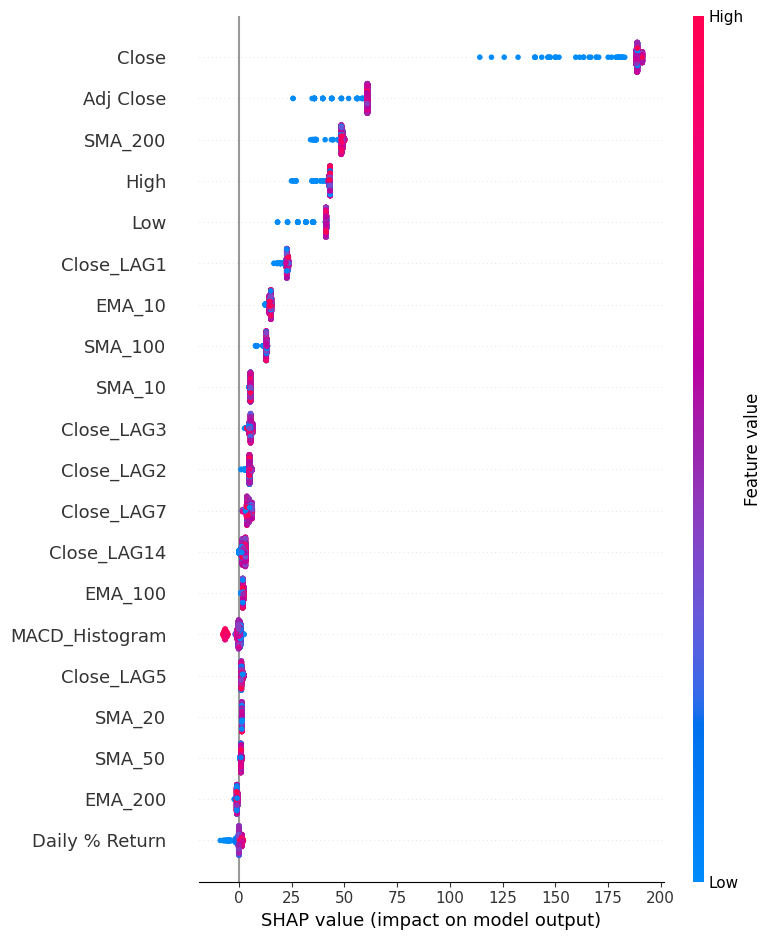

In [997]:
# ---- SHAP Explainability ----
import shap
explainer=shap.Explainer(best_xgb,x_train_next_day)
shap_values=explainer(x_test_next_day)

# Global feature importance (summary plot)
shap.summary_plot(shap_values,x_test_next_day)

# Single prediction explanation (force plot)
shap.plots.force(shap_values[0])  # explains first prediction

In [998]:
lgb_reg=LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

lgb_reg.fit(
    x_train_next_day,y_train_next_day,
    eval_set=[(x_test_next_day,y_test_next_day)],
    eval_metric='rmse',
    #early_stopping_rounds=50,
    #verbose=-1
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 5964, number of used features: 27
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 153.637183


LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=42)

In [999]:
lgb_pred=lgb_reg.predict(x_test_next_day)

In [1000]:
root_mean_squared_error(test_xgb,lgb_pred[:-1])

558.5959367243921

In [1001]:
mean_absolute_percentage_error(test_xgb,lgb_pred[:-1])*100

41.79221760063446